For our first taste of programming with Spark, we'll revisit the Lending Club dataset you first used earlier in the course. Instead of building a random forest though, we'll perform a logistic regression to determine the likelihood that someone will be approved for a loan.

Some notes:
* data loading: Pyspark can't naively load a csv from a URL so we want to copy the data file into our container and load from there. This isn't the case for something like HDFS however, you can load directly from Hadoop. For details see [here](https://spark.apache.org/docs/latest/rdd-programming-guide.html#external-datasets)
* Note on dropping columns - need to create a new dataframe. It won't remove columns in-place.

* Data prep strategy:
    1. Drop columns that have high portion of nulls. Only keep columns with fewer than 10 nulls total. Otherwise drop it.
    2. From remaining columns, review the schema and type. Cast any string columns that should be numeric into the appropriate value.
    3. Once all column types are correct, look at the categorical variables, and create the dummies as needed.
    
* Here is the big thing - the data then needs to be transformed from a multicolumn CSV dataframe into a label / feature RDD.
    * The RDD has to have only two columns: labels and a vector with all the features.
    * To achieve this we will combine remaining numeric variables and the dummy variables, then compress them into single row vectors.
    
* At that point data prep will be complete and we can run the random forest.

In [1]:
CSV_PATH = "/home/ds/notebooks/datasets/LoanStats3d.csv"
APP_NAME = "Lending Club Random Forest Example"
SPARK_URL = "local[*]"
RANDOM_SEED = 141107
TRAINING_DATA_RATIO = 0.7
RF_NUM_TREES = 10
RF_MAX_DEPTH = 4
RF_NUM_BINS = 32

In [2]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pprint import pprint

In [3]:
from pyspark import SparkContext
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName(APP_NAME) \
    .master(SPARK_URL) \
    .getOrCreate()

df = spark.read \
    .options(header = "true", inferschema = "true") \
    .csv(CSV_PATH)

In [4]:
from pyspark.sql.functions import isnan, when, count, col

null_counts = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) 
                         for c in df.columns]).toPandas().to_dict(orient='records')

In [5]:
pprint(null_counts[0])

{'acc_now_delinq': 1,
 'acc_open_past_24mths': 1,
 'addr_state': 0,
 'all_util': 399723,
 'annual_inc': 0,
 'annual_inc_joint': 420583,
 'application_type': 0,
 'avg_cur_bal': 0,
 'bc_open_to_buy': 3963,
 'bc_util': 4227,
 'chargeoff_within_12_mths': 0,
 'collection_recovery_fee': 0,
 'collections_12_mths_ex_med': 0,
 'debt_settlement_flag': 0,
 'debt_settlement_flag_date': 415607,
 'deferral_term': 419185,
 'delinq_2yrs': 0,
 'delinq_amnt': 0,
 'desc': 421050,
 'disbursement_method': 1,
 'dti': 2,
 'dti_joint': 420586,
 'earliest_cr_line': 0,
 'emp_length': 0,
 'emp_title': 23872,
 'funded_amnt': 0,
 'funded_amnt_inv': 0,
 'grade': 0,
 'hardship_amount': 419185,
 'hardship_dpd': 419185,
 'hardship_end_date': 419185,
 'hardship_flag': 1,
 'hardship_last_payment_amount': 419185,
 'hardship_length': 419185,
 'hardship_loan_status': 419185,
 'hardship_payoff_balance_amount': 419185,
 'hardship_reason': 419185,
 'hardship_start_date': 419185,
 'hardship_status': 419185,
 'hardship_type': 4

In [6]:
null_columns_to_drop = [key for key, value in null_counts[0].items() if value > 10]

In [7]:
pprint(null_columns_to_drop)

['id',
 'member_id',
 'emp_title',
 'url',
 'desc',
 'title',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'revol_util',
 'last_pymnt_d',
 'next_pymnt_d',
 'mths_since_last_major_derog',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'bc_open_to_buy',
 'bc_util',
 'mo_sin_old_il_acct',
 'mths_since_recent_bc',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'mths_since_recent_revol_delinq',
 'num_tl_120dpd_2m',
 'percent_bc_gt_75',
 'revol_bal_joint',
 'sec_app_earliest_cr_line',
 'sec_app_inq_last_6mths',
 'sec_app_mort_acc',
 'sec_app_open_acc',
 'sec_app_revol_util',
 'sec_app_open_act_il',
 'sec_app_num_rev_accts',
 'sec_app_chargeoff_within_12_mths',
 'sec_app_collections_12_mths_ex_med',
 'sec_app_mths_since_last_major_derog',


In [8]:
print(len(df.columns))
print(len(null_counts[0].keys()))
print(len(null_columns_to_drop))

145
145
69


In [9]:
df_updated = df.drop(*null_columns_to_drop)

In [10]:
print(len(df_updated.columns))

76


In [11]:
print("Total number of rows: %d" % df_updated.count())

Total number of rows: 421095


In [12]:
df_remove_na = df_updated.dropna()

In [13]:
print("Total number of rows: %d" % df_remove_na.count())

Total number of rows: 421082


In [14]:
null_counts_update = df_remove_na.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) 
                                        for c in df_remove_na.columns]).toPandas().to_dict(orient='records')

In [15]:
pprint(null_counts_update[0])

{'acc_now_delinq': 0,
 'acc_open_past_24mths': 0,
 'addr_state': 0,
 'annual_inc': 0,
 'application_type': 0,
 'avg_cur_bal': 0,
 'chargeoff_within_12_mths': 0,
 'collection_recovery_fee': 0,
 'collections_12_mths_ex_med': 0,
 'debt_settlement_flag': 0,
 'delinq_2yrs': 0,
 'delinq_amnt': 0,
 'disbursement_method': 0,
 'dti': 0,
 'earliest_cr_line': 0,
 'emp_length': 0,
 'funded_amnt': 0,
 'funded_amnt_inv': 0,
 'grade': 0,
 'hardship_flag': 0,
 'home_ownership': 0,
 'initial_list_status': 0,
 'inq_last_6mths': 0,
 'installment': 0,
 'int_rate': 0,
 'issue_d': 0,
 'last_credit_pull_d': 0,
 'last_pymnt_amnt': 0,
 'loan_amnt': 0,
 'loan_status': 0,
 'mo_sin_old_rev_tl_op': 0,
 'mo_sin_rcnt_rev_tl_op': 0,
 'mo_sin_rcnt_tl': 0,
 'mort_acc': 0,
 'num_accts_ever_120_pd': 0,
 'num_actv_bc_tl': 0,
 'num_actv_rev_tl': 0,
 'num_bc_sats': 0,
 'num_bc_tl': 0,
 'num_il_tl': 0,
 'num_op_rev_tl': 0,
 'num_rev_accts': 0,
 'num_rev_tl_bal_gt_0': 0,
 'num_sats': 0,
 'num_tl_30dpd': 0,
 'num_tl_90g_dpd_24

We've removed all null values from the dataset without removing too much information. This is a good thing but we're still not ready to run our random forest.

Next let's take a look at our updated dataframe schema.

In [16]:
df_remove_na.printSchema()

root
 |-- loan_amnt: integer (nullable = true)
 |-- funded_amnt: integer (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: string (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: string (nullable = true)
 |-- delinq_2yrs: double (nullable = true)
 |-- earliest_cr_line: string (nullable = true)
 |-- inq_last_6mths: string (nullable = true)
 |-- open_acc: integer (nullable = true)
 |-- pub_rec: integer (nul

We still have a ton of columns and we probably should look at reducing it further. 

Let's start by examining only the columns that are strings, and check whether we should convert them to a numeric datatype.

In [17]:
categoricals = [col[0] for col in df_remove_na.dtypes if col[1] == 'string']
print(len(categoricals))

27


So we can see that there are over 25 string columns. We're calling them "categorical" now but they're really only candidates to be categoricals. 

In fact, before we do that, we should take a quick look at the data in those columns to better understand if:
1. they're actually categorical
2. they are another type (likely numeric)
3. they can be removed because we think they don't contribute much information.
    * here we'll just use our experience, but in an actual analysis you should test for feature importance before removing any columns.

In [18]:
df_remove_na.select(categoricals[:6]).show(5)
df_remove_na.select(categoricals[6:12]).show(5)
df_remove_na.select(categoricals[12:17]).show(5)
df_remove_na.select(categoricals[17:22]).show(5)
df_remove_na.select(categoricals[22:]).show(5)

+----------+--------+-----+---------+----------+--------------+
|      term|int_rate|grade|sub_grade|emp_length|home_ownership|
+----------+--------+-----+---------+----------+--------------+
| 60 months|   9.80%|    B|       B3| 10+ years|      MORTGAGE|
| 60 months|  12.88%|    C|       C2|    1 year|      MORTGAGE|
| 36 months|  15.77%|    D|       D1|   2 years|      MORTGAGE|
| 36 months|  10.78%|    B|       B4|   8 years|          RENT|
| 36 months|   7.49%|    A|       A4| 10+ years|      MORTGAGE|
+----------+--------+-----+---------+----------+--------------+
only showing top 5 rows

+----------+-------------------+--------+-----------+----------+------------------+
|annual_inc|verification_status| issue_d|loan_status|pymnt_plan|           purpose|
+----------+-------------------+--------+-----------+----------+------------------+
|     65000|       Not Verified|Dec-2015| Fully Paid|         n|debt_consolidation|
|     70000|       Not Verified|Dec-2015|    Current|         n

We can see the following:
1. *loan_status* is our label - we'll need to change it to a numeric categorical variable and move it to the first column. The reasoning will become apparent later.

2. The following columns should be made numeric:
    * term 
    * int_rate
    * annual_inc
    * inq_last_6mths
    * total_acc
    * out_prncp
    * dti
    * last_payment_amnt
    * collections_12_mths_ex_med

3. The following columns can be dropped:
    * last_credit_pull_d
    * issue_d
    * zip_code
    * addr_state
    * earliest_cr_line
    * sub_grade
    * disbursement_method
    
This leaves 10 columns that are actually categorical and will need to be converted into dummy variables for our random forest.

First, let's convert to numeric.

This is a little more tedious than we'd like because each column has unique properties that don't lend to updating them via a loop.

In [19]:
from pyspark.sql.functions import split

split_col = split(df_remove_na['term'], ' ')
split_int_rate = split(df_remove_na['int_rate'], '%')

In [20]:
df_remove_na = df_remove_na.withColumn('term', split_col.getItem(1).cast("int"))
df_remove_na = df_remove_na.withColumn('int_rate', split_int_rate.getItem(0).cast("float"))
df_remove_na = df_remove_na.withColumn('annual_inc', df_remove_na['annual_inc'].cast("int"))
df_remove_na = df_remove_na.withColumn('inq_last_6mths', df_remove_na['inq_last_6mths'].cast("int"))
df_remove_na = df_remove_na.withColumn('total_acc', df_remove_na['total_acc'].cast("int"))
df_remove_na = df_remove_na.withColumn('out_prncp', df_remove_na['out_prncp'].cast("float"))
df_remove_na = df_remove_na.withColumn('dti', df_remove_na['dti'].cast("float"))
df_remove_na = df_remove_na.withColumn('last_pymnt_amnt', df_remove_na['last_pymnt_amnt'].cast("float"))
df_remove_na = df_remove_na.withColumn('collections_12_mths_ex_med', 
                                       df_remove_na['collections_12_mths_ex_med'].cast("int"))

Now we drop the remaining columns we noted above, and move the loan_status column to the first column position.

In [21]:
df_final = df_remove_na.drop('last_credit_pull_d', 'issue_d', 'zip_code', 
                             'addr_state', 'earliest_cr_line', 'disbursement_method', 'sub_grade')

cols = df_final.columns

cols.remove('loan_status')

final_cols = []
final_cols.append('loan_status')
final_cols.extend(cols)

df_final = df_final.select(*final_cols)

In [22]:
df_final.printSchema()

root
 |-- loan_status: string (nullable = true)
 |-- loan_amnt: integer (nullable = true)
 |-- funded_amnt: integer (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: integer (nullable = true)
 |-- int_rate: float (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: integer (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- dti: float (nullable = true)
 |-- delinq_2yrs: double (nullable = true)
 |-- inq_last_6mths: integer (nullable = true)
 |-- open_acc: integer (nullable = true)
 |-- pub_rec: integer (nullable = true)
 |-- revol_bal: integer (nullable = true)
 |-- total_acc: integer (nullable = true)
 |-- initial_list_status: string (nullable = true)
 |-- out_prncp: float (nullable = true)
 |-- out_prncp_inv: 

In [23]:
df_final.select(['term', 'int_rate']).show(10)

+----+--------+
|term|int_rate|
+----+--------+
|  60|     9.8|
|  60|   12.88|
|  36|   15.77|
|  36|   10.78|
|  36|    7.49|
|  60|   13.99|
|  60|   18.49|
|  36|   10.78|
|  60|   16.59|
|  36|   17.27|
+----+--------+
only showing top 10 rows



now we need to convert the categoricals to dummies

In [24]:
categoricals = [col[0] for col in df_final.dtypes if col[1] == 'string']
categoricals.remove('loan_status')
uniques = [df_final.select(col).distinct().count() for col in categoricals]
categorical_unique_counts = dict(zip(categoricals, uniques))

In [25]:
len(categoricals)

10

In [26]:
pprint(categorical_unique_counts)

{'application_type': 2,
 'debt_settlement_flag': 2,
 'emp_length': 12,
 'grade': 7,
 'hardship_flag': 2,
 'home_ownership': 4,
 'initial_list_status': 2,
 'purpose': 14,
 'pymnt_plan': 2,
 'verification_status': 3}


Most of these look good, but `emp_length` and `purpose` have a higher counts than the other variables. We should look at the labels of each variable to better understand what they are.

In [27]:
pprint(df_final.select('emp_length').distinct().rdd.map(lambda r: r[0]).collect())
pprint(df_final.select('purpose').distinct().rdd.map(lambda r: r[0]).collect())

['5 years',
 '9 years',
 '1 year',
 'n/a',
 '2 years',
 '7 years',
 '8 years',
 '4 years',
 '6 years',
 '3 years',
 '10+ years',
 '< 1 year']
['wedding',
 'educational',
 'other',
 'small_business',
 'debt_consolidation',
 'credit_card',
 'moving',
 'vacation',
 'renewable_energy',
 'house',
 'car',
 'major_purchase',
 'medical',
 'home_improvement']


After reviewing these,`emp_length` and `purpose` remain good candidates for dummies.

Let's take a look at the data in the dummy candidates one last time.

In [28]:
df_final.select(categoricals[:5]).show(10)
df_final.select(categoricals[5:]).show(10)

+-----+----------+--------------+-------------------+----------+
|grade|emp_length|home_ownership|verification_status|pymnt_plan|
+-----+----------+--------------+-------------------+----------+
|    B| 10+ years|      MORTGAGE|       Not Verified|         n|
|    C|    1 year|      MORTGAGE|       Not Verified|         n|
|    D|   2 years|      MORTGAGE|       Not Verified|         n|
|    B|   8 years|          RENT|    Source Verified|         n|
|    A| 10+ years|      MORTGAGE|       Not Verified|         n|
|    C| 10+ years|           OWN|    Source Verified|         n|
|    D| 10+ years|      MORTGAGE|           Verified|         n|
|    B|   3 years|          RENT|       Not Verified|         n|
|    D|   5 years|          RENT|       Not Verified|         n|
|    D| 10+ years|      MORTGAGE|           Verified|         n|
+-----+----------+--------------+-------------------+----------+
only showing top 10 rows

+------------------+-------------------+----------------+-------

Now we create our dummy variables.

There is no `get_dummies` equivalent, so we have to make a function for ourselves.

In [29]:
from pyspark.sql import functions as F
 
def create_dummies(df,dummylist):
    for inputcol in dummylist:
        categories = df.select(inputcol).rdd.distinct().flatMap(lambda x: x).collect()
        exprs = [F.when(F.col(inputcol) == category, 1).otherwise(0).alias(category) for category in categories]
        for index,column in enumerate(exprs):
            df=df.withColumn(inputcol+str(index),column)
    return df

df_final = create_dummies(df_final, categoricals)

Let's take a look at the categoricals and see if they've been recoded to numbers.

We see the updated dummy columns appended after the last column.

We can drop our string categoricals now.

In [30]:
df_final.printSchema()

root
 |-- loan_status: string (nullable = true)
 |-- loan_amnt: integer (nullable = true)
 |-- funded_amnt: integer (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: integer (nullable = true)
 |-- int_rate: float (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: integer (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- dti: float (nullable = true)
 |-- delinq_2yrs: double (nullable = true)
 |-- inq_last_6mths: integer (nullable = true)
 |-- open_acc: integer (nullable = true)
 |-- pub_rec: integer (nullable = true)
 |-- revol_bal: integer (nullable = true)
 |-- total_acc: integer (nullable = true)
 |-- initial_list_status: string (nullable = true)
 |-- out_prncp: float (nullable = true)
 |-- out_prncp_inv: 

In [31]:
df_final = df_final.drop(*categoricals)

If that drop worked, then we should only have one string column remaining - `loan_status`. Let's check that.

In [32]:
pprint([col[0] for col in df_final.dtypes if col[1] == 'string'])

['loan_status']


Before we move on, let's just do a quick frequency plot of the loan status so we can better understand what we are working with.

In [33]:
from matplotlib import pyplot as plt
import numpy as np
import functools
%matplotlib inline

([<matplotlib.axis.XTick at 0x7fd48f0d4b70>,
 <a list of 7 Text xticklabel objects>)

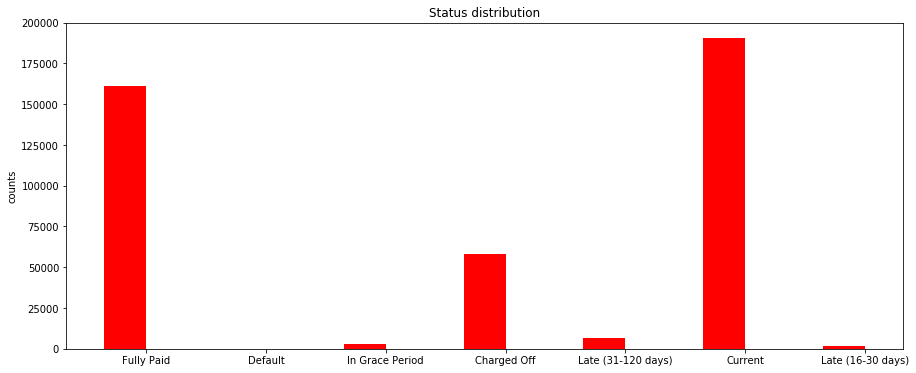

In [34]:
plt.rcParams['figure.figsize'] = (15, 6)
 
statuses = df_final.groupBy('loan_status').count().collect()
categories = [i[0] for i in statuses]
counts = [i[1] for i in statuses]
 
ind = np.array(range(len(categories)))
width = 0.35
plt.bar(ind, counts, width=width, color='r')
 
plt.ylabel('counts')
plt.title('Status distribution')
plt.xticks(ind + width/2., categories)

To set up our random forest, we need to do some final transformations and build a pipeline.


First, we need to convert our response variable (`loan_status`) into a numerical variable called `label`

(`label` is simply a standard you'll see in Spark)

In [35]:
labelIndexer = StringIndexer(inputCol="loan_status", outputCol="indexedLabel").fit(df_final)

feature_cols = [col[0] for col in df_final.dtypes if col[1] != 'string']

df_final = VectorAssembler(inputCols=feature_cols, outputCol="features").transform(df_final)

featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(df_final)

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = df_final.randomSplit([TRAINING_DATA_RATIO, 1 - TRAINING_DATA_RATIO])

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=RF_NUM_TREES)

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

In [38]:
# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

In [39]:
# Make predictions.
predictions = model.transform(testData)

In [47]:
# Select example rows to display.
predictions.select("predictedLabel", "loan_status", "indexedLabel", "prediction", "features").show(5)

+--------------+-----------+------------+----------+--------------------+
|predictedLabel|loan_status|indexedLabel|prediction|            features|
+--------------+-----------+------------+----------+--------------------+
|   Charged Off|Charged Off|         2.0|       2.0|(108,[0,1,2,3,4,5...|
|    Fully Paid|Charged Off|         2.0|       1.0|(108,[0,1,2,3,4,5...|
|    Fully Paid|Charged Off|         2.0|       1.0|(108,[0,1,2,3,4,5...|
|    Fully Paid|Charged Off|         2.0|       1.0|(108,[0,1,2,3,4,5...|
|   Charged Off|Charged Off|         2.0|       2.0|(108,[0,1,2,3,4,5...|
+--------------+-----------+------------+----------+--------------------+
only showing top 5 rows



In [46]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))
print("Accuracy = %g" % accuracy)

Test Error = 0.0540106
Accuracy = 0.945989


In [45]:
rfModel = model.stages[2]
print(rfModel)  # summary only

RandomForestClassificationModel (uid=RandomForestClassifier_45cfbf2e96c034a3cd7f) with 10 trees


In [ ]:
indexer = StringIndexer(inputCol="loan_status", outputCol="label")
indexed = indexer.fit(df_final).transform(df_final)
indexed.select('loan_status', 'label').show(25)